In [1]:
import pickle as pkl
import numpy as np
from envs.env_helper import *
import argparse
import os
from main import ENV_CONFIG
import torch
from agent.rfsac.rfsac_agent import RFVCritic, nystromVCritic
from gymnasium.wrappers.record_video import RecordVideo
from agent.rfsac import rfsac_agent
from agent.sac import sac_agent
from agent.sac.actor import DiagGaussianActor
from utils.util import eval_policy, visualize_policy, get_theta_traj

def eval(log_path, ):
    with open(os.path.join(log_path, 'train_params.pkl'), 'rb') as f:        
        kwargs = pkl.load(f)
    env_name = kwargs['env']
    
    eval_config = ENV_CONFIG.copy()
    eval_config.update({'reward_scale': 0.3,
                        'eval': True,
                        'reward_exponential': False,
                        'reward_type': 'energy',
                        'noise_scale': kwargs['sigma']})
    
    if env_name == "Pendulum-v1":
        env = gymnasium.make('Pendulum-v1', render_mode='human')
        eval_env = RescaleAction(env, min_action=-1., max_action=1.)
        # eval_env = RecordVideo(eval_env, video_folder=log_path)
    elif env_name == 'Quadrotor2D-v2':
        eval_env = env_creator_quad2d(eval_config)
    elif env_name == 'Pendubot-v0':
        eval_env = env_creator_pendubot(eval_config)
    elif env_name == 'CartPoleContinuous-v0':
        eval_env = env_creator_cartpole(eval_config)
    elif env_name == 'CartPendulum-v0':
        eval_env = env_creator_cartpendulum(eval_config)
    kwargs['action_space'] = eval_env.action_space

    use_nystrom = kwargs['use_nystrom']

    actor = DiagGaussianActor(obs_dim=kwargs['obs_space_dim'][0],
                              action_dim=kwargs['action_dim'],
                              hidden_dim=kwargs['hidden_dim'],
                              hidden_depth=2,
                              log_std_bounds=[-5., 2.])

    actor.load_state_dict(torch.load(log_path+"/actor_last.pth"))
    # critic.load_state_dict(torch.load(log_path + "/critic.pth"))
    agent = rfsac_agent.DensityConstrainedLagrangianAgent(**kwargs)
    agent.actor = actor
    agent.device = torch.device("cpu")

    thetas = get_theta_traj(agent, eval_env)

    return thetas

/home/mht/PycharmProjects/lvrep-rl-cloned/utils/util.py:67: DeprecationWarning: invalid escape sequence \p
  print(f"Evaluation over {eval_episodes} episodes: avg eplen {avg_len}, avg return {avg_ret:.3f} $\pm$ {std_ret:.3f}")


In [2]:
thetas = eval('/home/mht/PycharmProjects/lvrep-rl-cloned/log/Pendulum-v1_sigma_0.0_rew_scale_1.0/density_nystrom_False_rf_num_512_learn_rf_False/try_evaluate_density/0/')

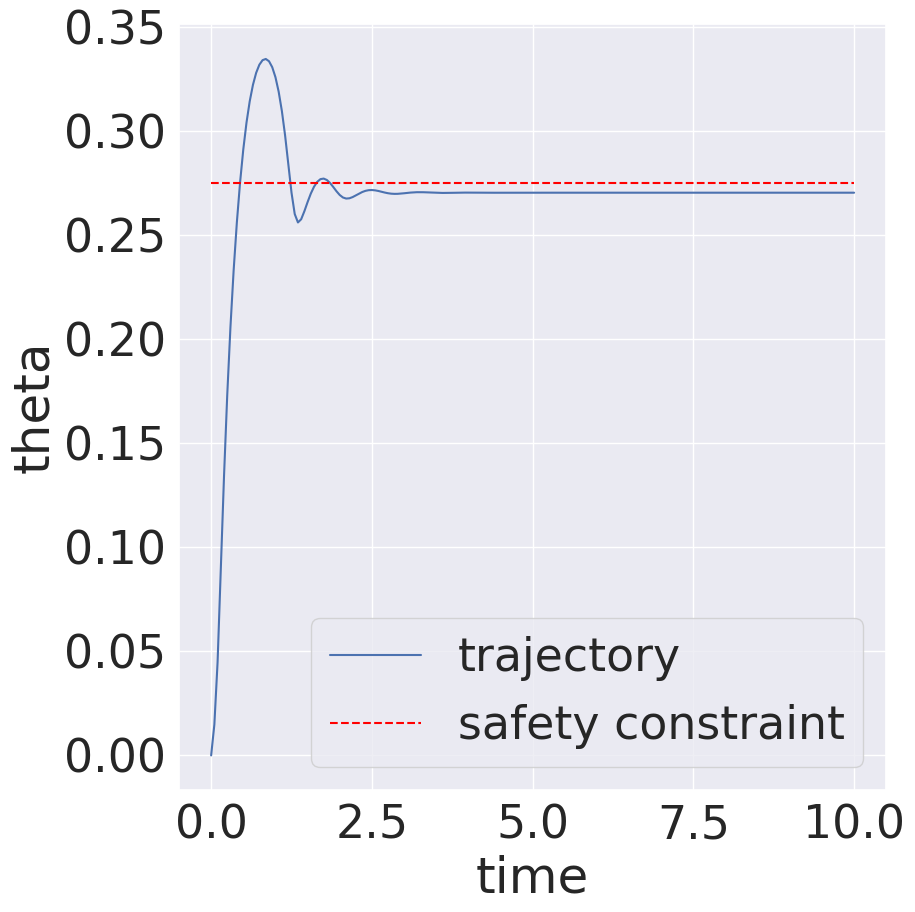

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.figure(figsize=[10,10])
sns.set(font_scale=3)
data = pd.DataFrame.from_dict({'time':np.arange(0, 10.05, 0.05), 'theta':thetas})
# sns.lineplot(data, x='time', y='theta')
plt.plot(np.arange(0, 10.05, 0.05),thetas, label='trajectory')
plt.xlabel('time')
plt.ylabel('theta')
plt.plot(np.arange(0, 10.05, 0.05), 0.275 * np.ones_like(thetas), linestyle='--', color='red', label='safety constraint')
# sns.set_style('')
plt.legend()
plt.tight_layout()
plt.savefig('safe.png')


In [9]:
len(np.arange(0, 10, 0.05))

200